# 위치로 속도 추정하기
- 잡음제거가 아닌 다른 목적으로 칼만필터를 사용하는 예제

### 예제 9-1
- 손칼만 연구원은 요즘 신형 열차의 성능 시험으로 바쁘다. 시험 내용은 직선 선로에서 열차가 80m/s의 속도를 유지하는지 확인하는 것이다. 위치와 속도 정보는 0.1초 간격으로 측정해서 저장하도록 되어 있다. 그런데 시험결과를 살펴보던 손칼만 연구원의 얼굴이 갑자기 사색으로 변했다. 속도 데이터가 모두 0으로 찍혀 있는 게 아닌가! 실험에 드는 비용과 시간이 만만치 않았는데, 이 사실을 위에서 알면 난리가 날 게 뻔하다. 그나마 다행인 것은 위치 정보는 이상이 없어 보인다는 점이다. 우리의 손칼만 연구원을 이 위기에서 구해 낼 방법은 없을까?

## 시스템 모델
- (속도) = (이동거리) / (시간) 의 공식대로 값을 구하면, 오차가 큼
- 이동평균, 다항식 근사 뒤 미분하는 것은 복잡할 뿐더러 오차가 큼 => 칼만필터로 해결가능

### 칼만필터 설계 (시스템 모델 설계)
- 열차의 위치와 속도를 상태변수로 정의
- 시스템 모델 설정 (xk, zk, A, H)

### 시스템 모델 확인 (예제 내용 반영하는지)
- 행렬 A와 상태변수의 정의 시스템 모델식에 대입
- 위치의 관계식 : 위치k+1 = 위치k + 속도k * t(시간간격)
    - (현재위치) = (직전위치) + (이동거리)의 물리법칙을 수식으로 표현
    - 잡음이 관계식에 포함되지 않음
    
- 속도 관계식 : 속도k+1 = 속도k + wk(시스템잡음)
    - 열차속도는 시스템 잡음의 영향만 받고, 외부영향은 받지 않음 (즉, 속도가 일정)
    - 시스템잡음은 마찰, 엔진 제어기의 오차 등 열차속도에 영향을 주는 모든 요인의 합
    
- 측정값 관계식(행렬 H를 측정값 관계식에 대입) : zk(측정값) = 위치k + vk(측정잡음)
    - 측정값은 위치 뿐이며, 측정값에 잡음이 섞여있음 (=예제와 일치함)

- 행렬 A와 H는 임의로 선정하는 것이 아닌, 시스템의 물리적관계 모델링한 결과물
- 즉, 시스템 모델은 속도와 거리 사이의 물리적 관계, 속도에 영향을 주는 오차 요인 등을 수학식으로 표현한 것

### 잡음의 공분산 행렬 (Q, R)
- 측정잡음(vk)의 오차특성은 보통 센서제작사에서 제공, 정보 없다면 직접 실험 또는 경험을 통해
- 시스템잡음(wk)의 모델링은 시스템에 대한 지식과 경험에 의존해야 함
- 논리적으로 Q와 R을 구하기 어렵다면, 두 행렬을 칼만필터의 설계인자로 보고 시행착오를 거쳐 선정하는 것도 한 방법

## 칼만필터 함수
- 매개변수 : z(위치 측정값)
- 반환값 : 위치 추정값, 속도 추정값

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

np.random.seed(0)

In [2]:
def get_pos_vel(itime, pos_true):
    """측정된 위치와 실제 속도 및 실제 위치 반환하는 함수"""
    w = np.random.normal(0, np.sqrt(10))      # w: system noise (시스템 소음)
    v = np.random.normal(0, np.sqrt(10))      # v: measurement noise (측정 소음)

    vel_true = 80 + w                         # nominal velocity = 80 [m/s].
    if itime == 0:
        pos_true = pos_true
    else:
        pos_true = pos_true + vel_true * dt
    z_pos_meas = pos_true + v                 # z_pos_meas: measured position (관찰가능한)
    return z_pos_meas, vel_true, pos_true

In [3]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm."""
    # (1) Prediction.
    x_pred = A @ x_esti
    P_pred = A @ P @ A.T + Q

    # (2) Kalman Gain.
    K = P_pred @ H.T @ inv(H @ P_pred @ H.T + R)

    # (3) Estimation.
    x_esti = x_pred + K @ (z_meas - H @ x_pred)

    # (4) Error Covariance.
    P = P_pred - K @ H @ P_pred

    return x_esti, P


In [5]:
# Input parameters. (0.1초마다 / 총 4초간)
time_end = 4
dt= 0.1

In [7]:
# Initialization for system model. (시스템모델 초기화)
# Matrix: A, H, Q, R, P_0 (행렬값)
# Vector: x_0 (벡터값)
A = np.array([[1, dt],
              [0, 1]])
H = np.array([[1, 0]])
Q = np.array([[1, 0],
              [0, 3]])
R = np.array([[10]])

# Initialization for estimation.
x_0 = np.array([0, 20])  # position and velocity
P_0 = 5 * np.eye(2) # 2 * 2 행렬 생성

In [8]:
time = np.arange(0, time_end, dt)
n_samples = len(time)
pos_meas_save = np.zeros(n_samples)
vel_true_save = np.zeros(n_samples)
pos_esti_save = np.zeros(n_samples)
vel_esti_save = np.zeros(n_samples)

In [9]:
pos_true = 0
x_esti, P = None, None
for i in range(n_samples):
    z_meas, vel_true, pos_true = get_pos_vel(i, pos_true)
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(z_meas, x_esti, P)

    pos_meas_save[i] = z_meas
    vel_true_save[i] = vel_true
    pos_esti_save[i] = x_esti[0]
    vel_esti_save[i] = x_esti[1]

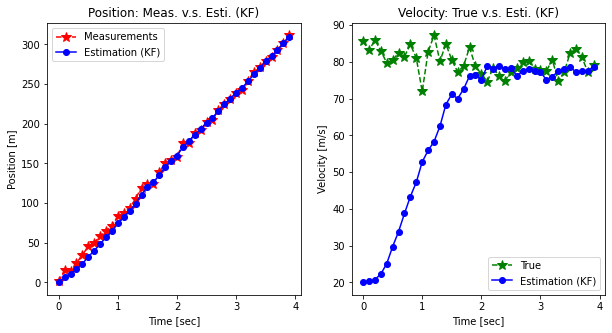

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(time, pos_meas_save, 'r*--', label='Measurements', markersize=10)
plt.plot(time, pos_esti_save, 'bo-', label='Estimation (KF)')
plt.legend(loc='upper left')
plt.title('Position: Meas. v.s. Esti. (KF)')
plt.xlabel('Time [sec]')
plt.ylabel('Position [m]')

plt.subplot(1, 2, 2)
plt.plot(time, vel_true_save, 'g*--', label='True', markersize=10)
plt.plot(time, vel_esti_save, 'bo-', label='Estimation (KF)')
plt.legend(loc='lower right')
plt.title('Velocity: True v.s. Esti. (KF)')
plt.xlabel('Time [sec]')
plt.ylabel('Velocity [m/s]')
plt.show()

- 왼쪽 그림의 파란선은 칼만필터의 추정위치, 빨간선은 측정값
- 측정잡음을 효과적으로 제거하여 추정위치의 궤적이 더 매끄러움


- 오른쪽 그림의 파란선은 칼만필터의 추정값, 초록색은 실제 속도값
- 초반에는 오차가 크지만, 2초 이후부터는 꽤 정확한 값으로 속도 추정

## 속도로 위치 추정하기
- 측정값이 위치에서 속도로 변경되었으므로 행렬 H가 달라져야 함
    - H = [1 0 ] --> H = [0 1]
- 행렬 H를 초기화하는 코드 빼고는 위와 같음

In [11]:
def get_pos_vel(itime):
    """Return Measured Velocity and True Position."""
    v = np.random.normal(0, np.sqrt(10))  # v: measurement noise.

    vel_true = 80                         # nominal velocity = 80 [m/s]. no system noise here.
    pos_true = vel_true * (itime * dt)    # pos_true: true position. 
    z_vel_meas = vel_true + v             # z_vel_meas: measured velocity (observable) 

    return z_vel_meas, pos_true

In [12]:
# Initialization for system model.
# Matrix: A, H, Q, R, P_0
# Vector: x_0
A = np.array([[1, dt],
              [0, 1]])
H = np.array([[0, 1]])
Q = np.array([[1, 0],
              [0, 3]])
R = np.array([[10]])

# Initialization for estimation.
x_0 = np.array([0, 20])  # position and velocity
P_0 = 5 * np.eye(2)

In [13]:
time = np.arange(0, time_end, dt)
n_samples = len(time)
vel_meas_save = np.zeros(n_samples)
pos_true_save = np.zeros(n_samples)
pos_esti_save = np.zeros(n_samples)
vel_esti_save = np.zeros(n_samples)

In [14]:
x_esti, P = None, None
for i in range(n_samples):
    z_meas, pos_true = get_pos_vel(i)
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(z_meas, x_esti, P)

    vel_meas_save[i] = z_meas
    pos_true_save[i] = pos_true
    pos_esti_save[i] = x_esti[0]
    vel_esti_save[i] = x_esti[1]

Text(0, 0.5, 'Position [m]')

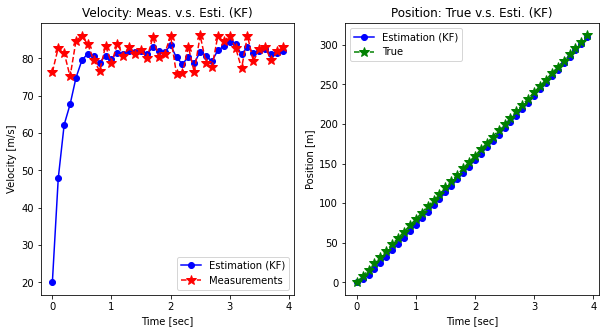

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(time, vel_esti_save, 'bo-', label='Estimation (KF)')
plt.plot(time, vel_meas_save, 'r*--', label='Measurements', markersize=10)
plt.legend(loc='lower right')
plt.title('Velocity: Meas. v.s. Esti. (KF)')
plt.xlabel('Time [sec]')
plt.ylabel('Velocity [m/s]')

plt.subplot(1, 2, 2)
plt.plot(time, pos_esti_save, 'bo-', label='Estimation (KF)')
plt.plot(time, pos_true_save, 'g*--', label='True', markersize=10)
plt.legend(loc='upper left')
plt.title('Position: True v.s. Esti. (KF)')
plt.xlabel('Time [sec]')
plt.ylabel('Position [m]')

- 추정속도 그래프 : 측정잡음이 제거된모습, 기준속도(80m/s) 근처에 추정속도 모여있는 모습 볼 수 있음
- 추정위치 그래프 : 평균속도(80m/s)에 따라 추정위치 움직이는 모습 볼 수 있음 (1초에 약 80m)

## 초음파 거리계로 속도 추정하기
- 속도가 일정하지 않은 경우에 위치로 속도 추정하기
- 거리와 속도의 물리적인 관계는 변하지 않기 때문에 같은 시스템모델 사용

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy import io

np.random.seed(0)

In [2]:
input_mat = io.loadmat('./data/9.DvKalman/SonarAlt.mat')

In [3]:
def get_sonar(i):
    """초음파 거리계 측정 데이터 가져오기"""
    z = input_mat['sonarAlt'][0][i]  # input_mat['sonaralt']: (1, 1501)
    return z

In [4]:
input_mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Thu Feb 25 13:19:03 2010',
 '__version__': '1.0',
 '__globals__': [],
 'sonarAlt': array([[34.25491256, 33.60223519, 33.60223519, ..., 36.55540305,
         36.55540305, 36.55540305]])}

In [5]:
def kalman_filter(z_meas, x_esti, P):
    # (1) Prediction.
    x_pred = A @ x_esti
    P_pred = A @ P @ A.T + Q

    # (2) Kalman Gain.
    K = P_pred @ H.T @ inv(H @ P_pred @ H.T + R)

    # (3) Estimation.
    x_esti = x_pred + K @ (z_meas - H @ x_pred)

    # (4) Error Covariance.
    P = P_pred - K @ H @ P_pred

    return x_esti, P

In [6]:
# Input parameters.
n_samples = 500
time_end = 10

In [7]:
# 시스템 모델 설정
# Matrix: A, H, Q, R, P_0
# Vector: x_0
dt = time_end / n_samples
A = np.array([[1, dt],
              [0, 1]])
H = np.array([[1, 0]])
Q = np.array([[1, 0],
              [0, 3]])
R = np.array([[10]])

# 추정값 최초 초기화
x_0 = np.array([0, 20])  # 위치 / 속도
P_0 = 5 * np.eye(2)

In [8]:
time = np.arange(0, time_end, dt)
z_pos_meas_save = np.zeros(n_samples)
x_pos_esti_save = np.zeros(n_samples)
x_vel_esti_save = np.zeros(n_samples)

In [9]:
x_esti, P = None, None
for i in range(n_samples):
    z_meas = get_sonar(i)
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(z_meas, x_esti, P)

    z_pos_meas_save[i] = z_meas
    x_pos_esti_save[i] = x_esti[0]
    x_vel_esti_save[i] = x_esti[1]

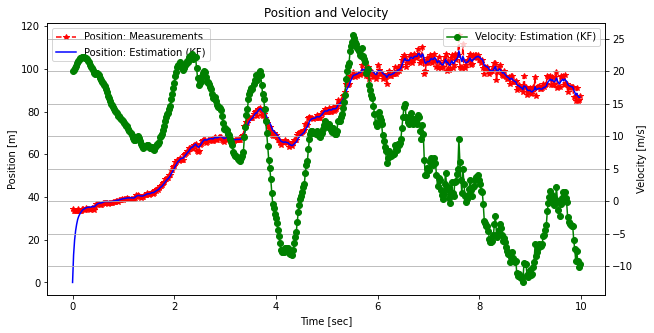

In [10]:
fig, ax1 = plt.subplots(figsize=(10, 5))
plt.plot(time, z_pos_meas_save, 'r*--', label='Position: Measurements')
plt.plot(time, x_pos_esti_save, 'b-', label='Position: Estimation (KF)')
plt.legend(loc='upper left')
plt.title('Position and Velocity')
plt.xlabel('Time [sec]')
plt.ylabel('Position [m]')

ax2 = ax1.twinx()
plt.plot(time, x_vel_esti_save, 'go-', label='Velocity: Estimation (KF)')
plt.legend(loc='upper right')
plt.ylabel('Velocity [m/s]')
plt.grid(True)

- 잡음제거 및 시간지연 영향 거의 보이지 않음 (잡음제거 및 변화민감성 문제 해결)
- 추정거리(파란색 실선)의 변화율과 추정속도 그래프의 궤적이 비슷한 형태를 띔 ==> 타당한 형태

## 효율적인 칼만 필터 함수
- 칼만이득(Kk)을 계산할 때 역행렬 계산해내야 함
    - 역행렬을 수치해석 기법으로 도출하는데, 이는 계산시간과 안정성에 악영향을 줌
- 위의 예제와 같이 시스템모델의 행렬이 작으면 (2*2) 행렬 계산식을 풀어쓰는 것이 계산시간과 오차를 줄이는 데 도움
- 간단한 행렬을 사용하는 행렬식을 풀어쓰면, 행렬수식이 스칼라 수식으로 변하고 수식이 간단해짐
    - 행렬식과 풀어쓴 계산식 동일값 도출 (물리법칙이 같기 때문)
- 상태변수가 많아져 시스템모델의 행렬이 커지면 이 방법 사용하기 어려움
    - 효율적인 수치해석 라이브러리 사용할 수 밖에 없음
    
## 시스템 모델의 힘

### 칼만필터가 측정하지 않은 값도 추정할 수 있는 이유
- 저주파 통과필터
    1. 측정신호에 대해 어떠한 가정도 하지 않음
    2. 새 측정값과 이전추정값에 가중치를 주고 더할 뿐이므로 측정하지 않은 물리량은 추정할 수 없음

- 칼만 필터
    1. 시스템의 수학적 모델 알고 있다고 가정 (= 측정값을 출력하는 법칙을 알고 있음)
    2. 상태변수 사이의 연관관계를 나타내는 시스템 모델을 통해 측정하지 않는 상태변수 간접 추정
    
- (예제) 추정속도는 시스템의 물리법칙(변수 사이의 관계)을 따라야하므로, 자연히 위치변화의 추이가 속도추정값에 반영됨

### 추정에 시스템 모델을 사용하는 것은 '양날의 검'
- 시스템 모델이 실제 시스템과 많이 다를 경우, 추정결과와 이를 넘어 전체시스템에 악영향을 줄 수 있음